# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# Data Extraction

In [ ]:
# --- CONFIGURATION ---
WINDOW_SIZE = 300     
POINTS_BEFORE = 130    
POINTS_AFTER = 170     
NORMAL_LABEL = 'N'
ARTIFACTS = ['+', '~', '|', 'Q', '?', '"']

def generate_training_dataset(signal_csv_path, annotation_txt_path, output_csv_path):
    print(f"Processing: {signal_csv_path}...")
    
    # 1. Load Signal Data
    try:
        sig_df = pd.read_csv(signal_csv_path)
        # Clean headers
        sig_df.columns = [c.strip().replace("'", "").replace('"', "") for c in sig_df.columns]
        signal_values = sig_df['MLII'].values 
    except KeyError:
        print(f"Error: Could not find 'MLII' in {sig_df.columns}")
        return

    # 2. Load Annotations
    ann_df = pd.read_csv(annotation_txt_path, sep=r'\s+', engine='python')
    
    # --- COLUMN DETECTION ---
    label_col_name = None
    sample_col_name = None
    
    # Look for the column that contains 'N' or '+' (common labels)
    for col in ann_df.columns:
        unique_vals = ann_df[col].astype(str).unique()
        if 'N' in unique_vals or '+' in unique_vals:
            label_col_name = col
        # Look for column with high numbers (indices)
        if ann_df[col].dtype == 'int64' and ann_df[col].max() > 1000:
            sample_col_name = col
            
    # Fallback if detection fails (Manual override based on your file structure)
    if label_col_name is None:
        # try accessing by Index
        print("Warning: Could not auto-detect label column. Using index 2.")
        label_col_name = ann_df.columns[2] 
        
    if sample_col_name is None:
        sample_col_name = ann_df.columns[1]

    print(f"Using '{label_col_name}' as Label Column and '{sample_col_name}' as Sample Index.")

    extracted_rows = []
    
    # 3. Main Loop
    for index, row in ann_df.iterrows():
        try:
            peak_idx = int(row[sample_col_name])
            label = str(row[label_col_name]).strip()
        except ValueError:
            continue 

        should_save = False 
        
        if label in ARTIFACTS:
            should_save = False
        elif label != NORMAL_LABEL:
            should_save = True  # Keep ALL Abnormal
        elif label == NORMAL_LABEL:
            if random.random() < 0.15: # Keep 15% Normal
                should_save = True

        if should_save:
            start_idx = peak_idx - POINTS_BEFORE
            end_idx = peak_idx + POINTS_AFTER
            
            if start_idx >= 0 and end_idx < len(signal_values):
                window = signal_values[start_idx : end_idx]
                row_data = list(window)
                row_data.append(label)
                extracted_rows.append(row_data)

    # 4. Save
    column_names = [str(i) for i in range(WINDOW_SIZE)] + ['label']
    output_df = pd.DataFrame(extracted_rows, columns=column_names)
    
    file_exists = os.path.isfile(output_csv_path)
    output_df.to_csv(output_csv_path, mode='a', header=not file_exists, index=False)
    
    print(f"Done! Saved {len(output_df)} beats.")
    print(f"- Normal: {len(output_df[output_df['label'] == 'N'])}")
    print(f"- Abnormal: {len(output_df[output_df['label'] != 'N'])}")
    

In [44]:
generate_training_dataset("mitbih_database/106.csv", "mitbih_database/106annotations.txt", "final_dataset.csv")

Processing: mitbih_database/106.csv...
Using '#' as Label Column and 'Sample' as Sample Index.
Done! Saved 749 beats.
- Normal: 229
- Abnormal: 520


# Data Cleaning and Normalization

In [ ]:
def normalize_and_clean_dataset(input_csv, output_csv):
    print(f"Loading {input_csv}...")
    df = pd.read_csv(input_csv)
    
    # Separate Signal from Labels
    signal_data = df.drop(columns=['label'])
    labels = df['label']
    
    print("Step 1: Denoising (Smoothing) signals...")
    # Apply a Rolling Mean (Moving Average)
    cleaned_signals = signal_data.rolling(window=5, center=True, axis=1).mean()
    
    cleaned_signals = cleaned_signals.fillna(signal_data)

    print("Step 2: Normalizing (Min-Max Scaling)...")
    # Row-by-Row Normalization
    row_mins = cleaned_signals.min(axis=1)
    row_maxs = cleaned_signals.max(axis=1)
    ranges = row_maxs - row_mins + 1e-9
    
    normalized_signals = cleaned_signals.sub(row_mins, axis=0).div(ranges, axis=0)
    
    # Round to 4 decimal places
    normalized_signals = normalized_signals.round(4)
    
    # Re-attach labels
    final_df = normalized_signals.copy()
    final_df['label'] = labels
    
    final_df.to_csv(output_csv, index=False)
    print(f"Success! Cleaned & Normalized data saved to {output_csv}")



In [47]:
# Run it on your visualization file (and your training file!)
normalize_and_clean_dataset('final_dataset.csv', 'normalized_dataset.csv')

Loading final_dataset.csv...
Step 1: Denoising (Smoothing) signals...
Step 2: Normalizing (Min-Max Scaling)...
Success! Cleaned & Normalized data saved to normalized_dataset.csv


C:\Users\homos\AppData\Local\Temp\ipykernel_30588\2238580651.py:13: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  cleaned_signals = signal_data.rolling(window=5, center=True, axis=1).mean()


# DP Stage

In [ ]:
# --- 1. CONFIGURATIONS ---
STATE_NAMES = ["Baseline", "P", "PR", "QRS", "ST", "T"]
NUM_STATES = len(STATE_NAMES)
INF = float('inf')

PREV_STATES = {
    0: [0, 5], 1: [1, 0], 2: [2, 1], 
    3: [3, 2], 4: [4, 3], 5: [5, 4]
}

# --- 2. THE COST FUNCTION ---
def get_emission_cost(voltage, state_index):
    
    if state_index in [0, 2, 4]: 
        return abs(voltage - 0.0) * 1.5  
    elif state_index in [1, 5]:
        dist_to_bump = abs(voltage - 0.2)
        dist_to_base = abs(voltage - 0.0)
        return min(dist_to_bump, dist_to_base * 0.8) 
    elif state_index == 3:
        if voltage < 0.15: return 10.0 
        return abs(voltage - 1.0) * 0.2
    return 100.0

# --- 3. THE VITERBI ALGORITHM ---
def run_viterbi(signal_array):

    N = len(signal_array)
    dp = [[INF] * NUM_STATES for _ in range(N)]
    path = [[0] * NUM_STATES for _ in range(N)]
    dp[0][0] = get_emission_cost(signal_array[0], 0)
    
    for t in range(1, N):
        val = signal_array[t]
        for curr in range(NUM_STATES):
            best_prev_cost = INF
            best_prev = -1
            for prev in PREV_STATES[curr]:
                trans_cost = 0.5 if prev != curr else 0.0
                total_cost = dp[t-1][prev] + get_emission_cost(val, curr) + trans_cost
                if total_cost < best_prev_cost:
                    best_prev_cost = total_cost
                    best_prev = prev
            dp[t][curr] = best_prev_cost
            path[t][curr] = best_prev

    final_state = 0
    min_final = INF
    for s in range(NUM_STATES):
        if dp[N-1][s] < min_final:
            min_final = dp[N-1][s]
            final_state = s
            
    best_path = [0] * N
    best_path[N-1] = final_state
    for t in range(N-1, 0, -1):
        prev = path[t][best_path[t]]
        best_path[t-1] = prev
        
    return [STATE_NAMES[i] for i in best_path]

# --- 4. THE INTEGRATION: FEATURE EXTRACTION ---
def extract_features(segment_labels, signal_values):
    """
    Input: 
      segment_labels: List of strings ['Baseline', 'P', 'P'...]
      signal_values: List of floats [0.01, 0.15, 0.16...]
    Output:
      List of 3 numerical features
    """
    # Feature 1: QRS Width (Duration)
    qrs_width = segment_labels.count("QRS")
    
    # Feature 2: ST Segment Level (The "Heart Attack" Indicator)
    # We take the AVERAGE voltage of the flat part between S and T
    st_indices = [i for i, x in enumerate(segment_labels) if x == "ST"]
    if st_indices:
        st_level = sum([signal_values[i] for i in st_indices]) / len(st_indices)
    else:
        st_level = 0.0 
        
    # Feature 3: PR Interval (Time from start of P to start of QRS)
    # We sum the duration of P and PR segments
    pr_interval = segment_labels.count("P") + segment_labels.count("PR")

    return [qrs_width, st_level, pr_interval]

# --- 5. UPDATED TEST DRIVER (WITH COMPLETED PLOTTING) ---
def test_on_dataset():
    # 1. Load Data
    try:
        df = pd.read_csv('normalized_dataset.csv')
    except FileNotFoundError:
        print("Error: normalized_dataset.csv not found.")
        return
    
    # 2. Pick Random Row
    random_row_idx = np.random.randint(0, len(df))
    row_data = df.iloc[random_row_idx]
    
    # Signal (0-300) and Label
    # We take all columns except the last one ('label')
    signal = row_data[:-1].values.astype(float)
    label = row_data['label']
    
    # 3. RUN DP (Get Strings)
    print(f"--- Processing Row {random_row_idx} (Label: {label}) ---")
    predicted_labels = run_viterbi(signal)
    
    # 4. RUN FEATURE EXTRACTION (Get Numbers)
    features = extract_features(predicted_labels, signal)
    
    # 5. DISPLAY RESULTS
    print("\n[DP Output Segments]")
    print(f"Sequence Length: {len(predicted_labels)}")
    print(f"First 20 labels: {predicted_labels[:20]}...")
    
    print("\n[Extracted Medical Features]")
    print(f"1. QRS Width:      {features[0]} samples")
    print(f"2. ST Seg Level:   {features[1]:.4f} (Normalized V)")
    print(f"3. PR Interval:    {features[2]} samples")
    
    # 6. PLOT THE RESULTS
    plt.figure(figsize=(12, 6))
    
    # A. Plot the original signal in Grey
    plt.plot(signal, color='black', alpha=0.3, linewidth=2, label='Raw Signal')
    
    # B. Overlay colored segments
    # Create an array of indices [0, 1, 2, ... 399]
    t_indices = np.arange(len(signal))
    
    # Convert list of strings to numpy array for easy filtering
    seg_array = np.array(predicted_labels)
    
    # Plot P-wave (Green)
    # logic: Find indices where label is 'P', plot those signal points
    plt.scatter(t_indices[seg_array == 'P'], signal[seg_array == 'P'], 
                color='green', s=15, label='P-wave (Atria)', zorder=5)
    
    # Plot QRS (Red)
    plt.scatter(t_indices[seg_array == 'QRS'], signal[seg_array == 'QRS'], 
                color='red', s=15, label='QRS (Ventricle)', zorder=5)

    # Plot T-wave (Blue)
    plt.scatter(t_indices[seg_array == 'T'], signal[seg_array == 'T'], 
                color='blue', s=15, label='T-wave (Recovery)', zorder=5)
    
    # C. Formatting
    # We display the Diagnosis and key extracted features in the title
    plt.title(f"Row {random_row_idx} | Diagnosis: {label} | QRS Width: {features[0]} | ST Level: {features[1]:.2f}", fontsize=14)
    plt.xlabel("Time (Samples)", fontsize=12)
    plt.ylabel("Normalized Voltage (0-1)", fontsize=12)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend(loc='upper right')
    
    plt.show()

--- Processing Row 790 (Label: V) ---

[DP Output Segments]
Sequence Length: 300
First 20 labels: ['Baseline', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']...

[Extracted Medical Features]
1. QRS Width:      114 samples
2. ST Seg Level:   0.2260 (Normalized V)
3. PR Interval:    25 samples


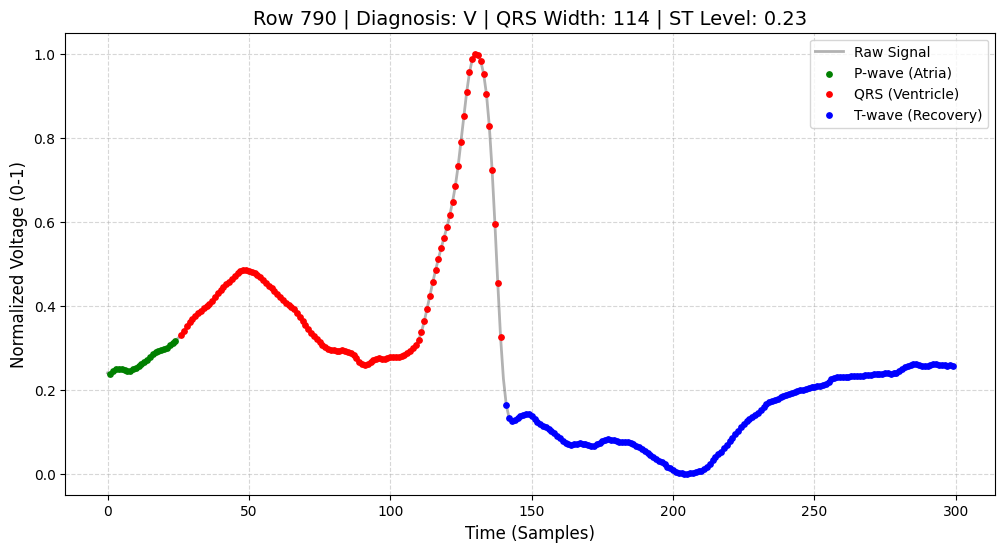

In [8]:
test_on_dataset()

# Feature Extraction

In [ ]:
def process_and_save_features(input_csv, output_csv):
    print(f"Loading {input_csv}...")
    try:
        df = pd.read_csv(input_csv)
    except FileNotFoundError:
        print(f"Error: {input_csv} not found.")
        return

    # Prepare lists to store the processed data
    processed_data = []
    
    total_rows = len(df)
    print(f"Starting batch processing of {total_rows} heartbeats...")

    for idx, row in df.iterrows():
        # 1. Get Signal (first 300 cols) and Label
        signal = row[:-1].values.astype(float)
        label = row['label']
        
        # 2. Run DP (Segmentation)
        segment_labels = run_viterbi(signal)
        
        # 3. Extract Features (Translation)
        # Returns [qrs_width, st_level, pr_interval]
        feats = extract_features(segment_labels, signal)
        
        # 4. Append Label to the features so we have X and y together
        row_result = feats + [label]
        processed_data.append(row_result)
        
        # Print progress every 100 rows
        if idx % 100 == 0:
            print(f"Processed {idx}/{total_rows} rows...", end='\r')

    print(f"\nProcessing complete! Saving to {output_csv}...")
    
    # Define concise column names for the new file
    feature_cols = [
        "QRS_Width", 
        "ST_Level", 
        "PR_Interval", 
        "Label"
    ]
    
    # Create and Save DataFrame
    output_df = pd.DataFrame(processed_data, columns=feature_cols)
    output_df.to_csv(output_csv, index=False)
    
    print("Success! File saved.")
    print(output_df.head())

In [54]:
# --- RUN THE PROCESSING ---
# This will create 'processed_features.csv'
process_and_save_features('normalized_dataset.csv', 'processed_features.csv')

Loading normalized_dataset.csv...
Starting batch processing of 1107 heartbeats...
Processed 1100/1107 rows...
Processing complete! Saving to processed_features.csv...
Success! File saved.
   QRS_Width  R_Peak_Height  P_Wave_Present  T_Wave_Present  ST_Level  \
0         12            1.0               1               1    0.1523   
1         12            1.0               1               1    0.0722   
2         16            1.0               1               1    0.1095   
3         12            1.0               1               1    0.1261   
4         12            1.0               1               1    0.1121   

   PR_Interval Label  
0          123     A  
1          123     N  
2          121     N  
3          123     N  
4          123     N  
